In [ ]:
!pip install tensorflow>=2.11.0 scipy>=1.10.0 opencv-python>=4.7.0 gym==0.19.0
!pip install "gym[atari, accept-rom-license]"

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
from concurrent import futures
from dopamine.replay_memory import circular_replay_buffer
from tqdm import tqdm

import numpy as np
import tensorflow.compat.v1 as tf

import gin

from tensorflow_datasets.rl_unplugged import atari_utils, rlu_common
import functools
import tensorflow_datasets as tfds
!pip install torch_optimizer
import torch_optimizer as optim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 751.1 kB/s eta 0:00:00


In [9]:
def get_episode(episode):

    example = tf.train.Example()
    example.ParseFromString(episode.numpy())

    results = {}
    # example.features.feature is the feature dictionary
    for key, feature in example.features.feature.items():
        kind = feature.WhichOneof('kind')
        results[key] = np.array(getattr(feature, kind).value)

    results['RTG'] = results['episode_return'] - np.cumsum(results['clipped_rewards'])
    # results['RTG'] = 21 - torch.cumsum(results['clipped_rewards']==-1, dim=-1)
    # print(results['RTG'][-1])
    # print(results['RTG'])
    # print(results["actions"])
    # print(results['actions'][0:50])
    # total = np.sum(results['actions'])
    # print(np.mean(results['actions']==0))
    # print(np.mean(results['actions']==1))
    # print(np.mean(results['actions']==2))
    # print(np.mean(results['actions']==3))
    # print(np.mean(results['actions']==4))
    # print(np.mean(results['actions']==5))
    return results['observations'], results['RTG'], results['actions'], results['clipped_rewards']



In [10]:
# Download dataset for Pong (additional games can be added as needed)
# !mkdir /content/dataset
#!gsutil -m cp -R gs://atari-replay-datasets/dqn/Pong /content/dataset

# code to physically download shard, but wrong format...
# !gsutil -m cp -R gs://rl_unplugged/atari/Pong/run_1-00000-of-00100 /content/dataset/Pong_1

def load_shard(shard_to_load):
    input_prefix = "gs://rl_unplugged/atari_episodes_ordered/"
    game = "Pong"
    run = 1
    file_prefix = atari_utils.file_prefix(input_prefix, run, game)
    file_to_load = rlu_common.filename(
                prefix=file_prefix,
                num_shards=50,
                shard_id=shard_to_load,
            )
    ds = tf.data.TFRecordDataset(
        filenames=str(file_to_load), compression_type='GZIP'
    )
    return ds

def load_shard_from_local(shard_to_load):
    file = "/content/dataset/Pong_" + str(shard_to_load)

    ds = tf.data.TFRecordDataset(
        filenames=file, compression_type='GZIP'
    )
    return ds

def download_data():
    pass

def count_shard_length(ds):
    counter = 0
    total_steps = 0
    for ep in ds:
        counter+=1
        total_steps += len(get_episode(ep)[0])
    return counter, total_steps



In [ ]:
for i in reversed(range(45,50)):
    bucket = "gs://rl_unplugged/atari_episodes_ordered/Pong/run_1-000" + str(i) + "-of-00050"
    directory = "/content/dataset/Pong_" + str(i)
    !gsutil -m cp -R $bucket $directory


In [8]:
# count shard lengths
for i in range(45,50):
    ds = load_shard_from_local(i)
    counter, total_steps = count_shard_length(ds)
    print(counter)
    print(total_steps)

482
998557
482
998557
482
998557
483
998554
480
998563


In [11]:
def _decode_images(pngs):
  """Decode tensor of PNGs."""

  num_channels = 1  # everything is grayscale

#   decode_rgb_png = functools.partial(tf.io.decode_png, channels=num_channels)
  triple = lambda img: tf.io.decode_jpeg(tf.io.encode_jpeg(tf.io.decode_png(img)))
  decode_rgb_png_jpeg = functools.partial(triple)
  images = tf.map_fn(decode_rgb_png_jpeg, pngs, dtype=tf.uint8,
                     parallel_iterations=10)
#   images.set_shape((pngs.shape[0], 84, 84, num_channels))
  return images

# images = _decode_images(result['observations'])

In [12]:
import matplotlib.pyplot as plt

# print(images[1301][2][2])

# # Visualize image
# image_to_visualize = images[1301]  # Change the index as needed

# # print(image_to_visualize.numpy())

# # Display the image using Matplotlib
# plt.imshow(image_to_visualize.numpy().squeeze()/255.0, cmap='gray')
# plt.title("Decoded PNG Image")
# plt.axis('off')  # To hide the axis labels and ticks

# Show the image
# plt.show()

# atari data

In [13]:
# from https://github.com/deepmind/dqn_zoo/blob/807379c19f8819e407329ac1b95dcaccb9d536c3/dqn_zoo/atari_data.py

# Copyright 2019 DeepMind Technologies Limited. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Utilities to compute human-normalized Atari scores.

The data used in this module is human and random performance data on Atari-57.
It comprises of evaluation scores (undiscounted returns), each averaged
over at least 3 episode runs, on each of the 57 Atari games. Each episode begins
with the environment already stepped with a uniform random number (between 1 and
30 inclusive) of noop actions.

The two agents are:
* 'random' (agent choosing its actions uniformly randomly on each step)
* 'human' (professional human game tester)

Scores are obtained by averaging returns over the episodes played by each agent,
with episode length capped to 108,000 frames (i.e. timeout after 30 minutes).

The term 'human-normalized' here means a linear per-game transformation of
a game score in such a way that 0 corresponds to random performance and 1
corresponds to human performance.
"""

# pylint: disable=g-bad-import-order



# Game: score-tuple dictionary. Each score tuple contains
#  0: score random (float) and 1: score human (float).
_ATARI_DATA = {
    "alien": (227.8, 7127.7),
    "amidar": (5.8, 1719.5),
    "assault": (222.4, 742.0),
    "asterix": (210.0, 8503.3),
    "asteroids": (719.1, 47388.7),
    "atlantis": (12850.0, 29028.1),
    "bank_heist": (14.2, 753.1),
    "battle_zone": (2360.0, 37187.5),
    "beam_rider": (363.9, 16926.5),
    "berzerk": (123.7, 2630.4),
    "bowling": (23.1, 160.7),
    "boxing": (0.1, 12.1),
    "breakout": (1.7, 30.5),
    "centipede": (2090.9, 12017.0),
    "chopper_command": (811.0, 7387.8),
    "crazy_climber": (10780.5, 35829.4),
    "defender": (2874.5, 18688.9),
    "demon_attack": (152.1, 1971.0),
    "double_dunk": (-18.6, -16.4),
    "enduro": (0.0, 860.5),
    "fishing_derby": (-91.7, -38.7),
    "freeway": (0.0, 29.6),
    "frostbite": (65.2, 4334.7),
    "gopher": (257.6, 2412.5),
    "gravitar": (173.0, 3351.4),
    "hero": (1027.0, 30826.4),
    "ice_hockey": (-11.2, 0.9),
    "jamesbond": (29.0, 302.8),
    "kangaroo": (52.0, 3035.0),
    "krull": (1598.0, 2665.5),
    "kung_fu_master": (258.5, 22736.3),
    "montezuma_revenge": (0.0, 4753.3),
    "ms_pacman": (307.3, 6951.6),
    "name_this_game": (2292.3, 8049.0),
    "phoenix": (761.4, 7242.6),
    "pitfall": (-229.4, 6463.7),
    "pong": (-20.7, 14.6),
    "private_eye": (24.9, 69571.3),
    "qbert": (163.9, 13455.0),
    "riverraid": (1338.5, 17118.0),
    "road_runner": (11.5, 7845.0),
    "robotank": (2.2, 11.9),
    "seaquest": (68.4, 42054.7),
    "skiing": (-17098.1, -4336.9),
    "solaris": (1236.3, 12326.7),
    "space_invaders": (148.0, 1668.7),
    "star_gunner": (664.0, 10250.0),
    "surround": (-10.0, 6.5),
    "tennis": (-23.8, -8.3),
    "time_pilot": (3568.0, 5229.2),
    "tutankham": (11.4, 167.6),
    "up_n_down": (533.4, 11693.2),
    "venture": (0.0, 1187.5),
    # Note the random agent score on Video Pinball is sometimes greater than the
    # human score under other evaluation methods.
    "video_pinball": (16256.9, 17667.9),
    "wizard_of_wor": (563.5, 4756.5),
    "yars_revenge": (3092.9, 54576.9),
    "zaxxon": (32.5, 9173.3),
}

_RANDOM_COL = 0
_HUMAN_COL = 1

ATARI_GAMES = tuple(sorted(_ATARI_DATA.keys()))


def get_human_normalized_score(game: str, raw_score: float) -> float:
    """Converts game score to human-normalized score."""
    game_scores = _ATARI_DATA.get(game, (math.nan, math.nan))
    random, human = game_scores[_RANDOM_COL], game_scores[_HUMAN_COL]
    return (raw_score - random) / (human - random)

# atari preprocessing

In [14]:
# from https://github.com/facebookresearch/moolib/blob/06e7a3e80c9f52729b4a6159f3fb4fc78986c98e/examples/atari/atari_preprocessing.py

# coding=utf-8
# Copyright 2019 The SEED Authors
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""A class implementing minimal Atari 2600 preprocessing.

Adapted from Dopamine.
"""

import cv2
import gym
import numpy as np
from gym.spaces.box import Box


class AtariPreprocessing(gym.Wrapper):
    """A class implementing image preprocessing for Atari 2600 agents.

    Specifically, this provides the following subset from the JAIR paper
    (Bellemare et al., 2013) and Nature DQN paper (Mnih et al., 2015):

      * Frame skipping (defaults to 4).
      * Terminal signal when a life is lost (off by default).
      * Grayscale and max-pooling of the last two frames.
      * Downsample the screen to a square image (defaults to 84x84).

    More generally, this class follows the preprocessing guidelines set down in
    Machado et al. (2018), "Revisiting the Arcade Learning Environment:
    Evaluation Protocols and Open Problems for General Agents".

    It also provides random starting no-ops, which are used in the Rainbow, Apex
    and R2D2 papers.
    """

    def __init__(self, env, frame_skip=4, terminal_on_life_loss=False, screen_size=84, max_random_noops=0):
        """Constructor for an Atari 2600 preprocessor.

        Args:
          env: Gym environment whose observations are preprocessed.
          frame_skip: int, the frequency at which the agent experiences the game.
          terminal_on_life_loss: bool, If True, the step() method returns
            is_terminal=True whenever a life is lost. See Mnih et al. 2015.
          screen_size: int, size of a resized Atari 2600 frame.
          max_random_noops: int, maximum number of no-ops to apply at the beginning
            of each episode to reduce determinism. These no-ops are applied at a
            low-level, before frame skipping.

        Raises:
          ValueError: if frame_skip or screen_size are not strictly positive.
        """
        super().__init__(env)
        if frame_skip <= 0:
            raise ValueError("Frame skip should be strictly positive, got {}".format(frame_skip))
        if screen_size <= 0:
            raise ValueError("Target screen size should be strictly positive, got {}".format(screen_size))

        self.terminal_on_life_loss = terminal_on_life_loss
        self.frame_skip = frame_skip
        self.screen_size = screen_size
        self.max_random_noops = max_random_noops

        obs_dims = self.env.observation_space
        # Stores temporary observations used for pooling over two successive
        # frames.
        self.screen_buffer = [
            np.empty((obs_dims.shape[0], obs_dims.shape[1]), dtype=np.uint8),
            np.empty((obs_dims.shape[0], obs_dims.shape[1]), dtype=np.uint8),
        ]

        self.game_over = False
        self.lives = 0  # Will need to be set by reset().

    @property
    def observation_space(self):
        # Return the observation space adjusted to match the shape of the processed
        # observations.
        return Box(low=0, high=255, shape=(self.screen_size, self.screen_size), dtype=np.uint8)

    def apply_random_noops(self):
        """Steps self.env with random no-ops."""
        if self.max_random_noops <= 0:
            return
        # Other no-ops implementations actually always do at least 1 no-op. We
        # follow them.
        no_ops = self.env.np_random.integers(1, self.max_random_noops + 1)
        for _ in range(no_ops):
            _, _, game_over, _ = self.env.step(0)
            if game_over:
                self.env.reset()

    def reset(self, **kwargs):
        """Resets the environment.

        Returns:
          observation: numpy array, the initial observation emitted by the
            environment.
        """
        self.env.reset(**kwargs)
        self.apply_random_noops()

        self.lives = self.env.ale.lives()
        self._fetch_grayscale_observation(self.screen_buffer[0])
        self.screen_buffer[1].fill(0)
        return self._pool_and_resize()

    def render(self, mode):
        """Renders the current screen, before preprocessing.

        This calls the Gym API's render() method.

        Args:
          mode: Mode argument for the environment's render() method.
            Valid values (str) are:
              'rgb_array': returns the raw ALE image.
              'human': renders to display via the Gym renderer.

        Returns:
          if mode='rgb_array': numpy array, the most recent screen.
          if mode='human': bool, whether the rendering was successful.
        """
        return self.env.render(mode)

    def step(self, action):
        """Applies the given action in the environment.

        Remarks:

          * If a terminal state (from life loss or episode end) is reached, this may
            execute fewer than self.frame_skip steps in the environment.
          * Furthermore, in this case the returned observation may not contain valid
            image data and should be ignored.

        Args:
          action: The action to be executed.

        Returns:
          observation: numpy array, the observation following the action.
          reward: float, the reward following the action.
          is_terminal: bool, whether the environment has reached a terminal state.
            This is true when a life is lost and terminal_on_life_loss, or when the
            episode is over.
          info: Gym API's info data structure.
        """
        accumulated_reward = 0.0

        for time_step in range(self.frame_skip):
            # We bypass the Gym observation altogether and directly fetch the
            # grayscale image from the ALE. This is a little faster.
            _, reward, game_over, info = self.env.step(action)
            accumulated_reward += reward

            if self.terminal_on_life_loss:
                new_lives = self.env.ale.lives()
                is_terminal = game_over or new_lives < self.lives
                self.lives = new_lives
            else:
                is_terminal = game_over

            if is_terminal:
                break
            # We max-pool over the last two frames, in grayscale.
            elif time_step >= self.frame_skip - 2:
                t = time_step - (self.frame_skip - 2)
                self._fetch_grayscale_observation(self.screen_buffer[t])

        # Pool the last two observations.
        observation = self._pool_and_resize()

        self.game_over = game_over
        return observation, accumulated_reward, is_terminal, info

    def _fetch_grayscale_observation(self, output):
        """Returns the current observation in grayscale.

        The returned observation is stored in 'output'.

        Args:
          output: numpy array, screen buffer to hold the returned observation.

        Returns:
          observation: numpy array, the current observation in grayscale.
        """
        self.env.ale.getScreenGrayscale(output)
        return output

    def _pool_and_resize(self):
        """Transforms two frames into a Nature DQN observation.

        For efficiency, the transformation is done in-place in self.screen_buffer.

        Returns:
          transformed_screen: numpy array, pooled, resized screen.
        """
        # Pool if there are enough screens to do so.
        if self.frame_skip > 1:
            np.maximum(self.screen_buffer[0], self.screen_buffer[1], out=self.screen_buffer[0])

        transformed_image = cv2.resize(
            self.screen_buffer[0], (self.screen_size, self.screen_size), interpolation=cv2.INTER_LINEAR
        )
        return np.asarray(transformed_image, dtype=np.uint8)# from https://github.com/facebookresearch/moolib/blob/06e7a3e80c9f52729b4a6159f3fb4fc78986c98e/examples/atari/atari_preprocessing.py

# coding=utf-8
# Copyright 2019 The SEED Authors
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""A class implementing minimal Atari 2600 preprocessing.

Adapted from Dopamine.
"""

import cv2
import gym
import numpy as np
from gym.spaces.box import Box


class AtariPreprocessing(gym.Wrapper):
    """A class implementing image preprocessing for Atari 2600 agents.

    Specifically, this provides the following subset from the JAIR paper
    (Bellemare et al., 2013) and Nature DQN paper (Mnih et al., 2015):

      * Frame skipping (defaults to 4).
      * Terminal signal when a life is lost (off by default).
      * Grayscale and max-pooling of the last two frames.
      * Downsample the screen to a square image (defaults to 84x84).

    More generally, this class follows the preprocessing guidelines set down in
    Machado et al. (2018), "Revisiting the Arcade Learning Environment:
    Evaluation Protocols and Open Problems for General Agents".

    It also provides random starting no-ops, which are used in the Rainbow, Apex
    and R2D2 papers.
    """

    def __init__(self, env, frame_skip=4, terminal_on_life_loss=False, screen_size=84, max_random_noops=0):
        """Constructor for an Atari 2600 preprocessor.

        Args:
          env: Gym environment whose observations are preprocessed.
          frame_skip: int, the frequency at which the agent experiences the game.
          terminal_on_life_loss: bool, If True, the step() method returns
            is_terminal=True whenever a life is lost. See Mnih et al. 2015.
          screen_size: int, size of a resized Atari 2600 frame.
          max_random_noops: int, maximum number of no-ops to apply at the beginning
            of each episode to reduce determinism. These no-ops are applied at a
            low-level, before frame skipping.

        Raises:
          ValueError: if frame_skip or screen_size are not strictly positive.
        """
        super().__init__(env)
        if frame_skip <= 0:
            raise ValueError("Frame skip should be strictly positive, got {}".format(frame_skip))
        if screen_size <= 0:
            raise ValueError("Target screen size should be strictly positive, got {}".format(screen_size))

        self.terminal_on_life_loss = terminal_on_life_loss
        self.frame_skip = frame_skip
        self.screen_size = screen_size
        self.max_random_noops = max_random_noops

        obs_dims = self.env.observation_space
        # Stores temporary observations used for pooling over two successive
        # frames.
        self.screen_buffer = [
            np.empty((obs_dims.shape[0], obs_dims.shape[1]), dtype=np.uint8),
            np.empty((obs_dims.shape[0], obs_dims.shape[1]), dtype=np.uint8),
        ]

        self.game_over = False
        self.lives = 0  # Will need to be set by reset().

    @property
    def observation_space(self):
        # Return the observation space adjusted to match the shape of the processed
        # observations.
        return Box(low=0, high=255, shape=(self.screen_size, self.screen_size), dtype=np.uint8)

    def apply_random_noops(self):
        """Steps self.env with random no-ops."""
        if self.max_random_noops <= 0:
            return
        # Other no-ops implementations actually always do at least 1 no-op. We
        # follow them.
        no_ops = self.env.np_random.integers(1, self.max_random_noops + 1)
        for _ in range(no_ops):
            _, _, game_over, _ = self.env.step(0)
            if game_over:
                self.env.reset()

    def reset(self, **kwargs):
        """Resets the environment.

        Returns:
          observation: numpy array, the initial observation emitted by the
            environment.
        """
        self.env.reset(**kwargs)
        self.apply_random_noops()

        self.lives = self.env.ale.lives()
        self._fetch_grayscale_observation(self.screen_buffer[0])
        self.screen_buffer[1].fill(0)
        return self._pool_and_resize()

    def render(self, mode):
        """Renders the current screen, before preprocessing.

        This calls the Gym API's render() method.

        Args:
          mode: Mode argument for the environment's render() method.
            Valid values (str) are:
              'rgb_array': returns the raw ALE image.
              'human': renders to display via the Gym renderer.

        Returns:
          if mode='rgb_array': numpy array, the most recent screen.
          if mode='human': bool, whether the rendering was successful.
        """
        return self.env.render(mode)

    def step(self, action):
        """Applies the given action in the environment.

        Remarks:

          * If a terminal state (from life loss or episode end) is reached, this may
            execute fewer than self.frame_skip steps in the environment.
          * Furthermore, in this case the returned observation may not contain valid
            image data and should be ignored.

        Args:
          action: The action to be executed.

        Returns:
          observation: numpy array, the observation following the action.
          reward: float, the reward following the action.
          is_terminal: bool, whether the environment has reached a terminal state.
            This is true when a life is lost and terminal_on_life_loss, or when the
            episode is over.
          info: Gym API's info data structure.
        """
        accumulated_reward = 0.0

        for time_step in range(self.frame_skip):
            # We bypass the Gym observation altogether and directly fetch the
            # grayscale image from the ALE. This is a little faster.
            _, reward, game_over, info = self.env.step(action)
            accumulated_reward += reward

            if self.terminal_on_life_loss:
                new_lives = self.env.ale.lives()
                is_terminal = game_over or new_lives < self.lives
                self.lives = new_lives
            else:
                is_terminal = game_over

            if is_terminal:
                break
            # We max-pool over the last two frames, in grayscale.
            elif time_step >= self.frame_skip - 2:
                t = time_step - (self.frame_skip - 2)
                self._fetch_grayscale_observation(self.screen_buffer[t])

        # Pool the last two observations.
        observation = self._pool_and_resize()

        self.game_over = game_over
        return observation, accumulated_reward, is_terminal, info

    def _fetch_grayscale_observation(self, output):
        """Returns the current observation in grayscale.

        The returned observation is stored in 'output'.

        Args:
          output: numpy array, screen buffer to hold the returned observation.

        Returns:
          observation: numpy array, the current observation in grayscale.
        """
        self.env.ale.getScreenGrayscale(output)
        return output

    def _pool_and_resize(self):
        """Transforms two frames into a Nature DQN observation.

        For efficiency, the transformation is done in-place in self.screen_buffer.

        Returns:
          transformed_screen: numpy array, pooled, resized screen.
        """
        # Pool if there are enough screens to do so.
        if self.frame_skip > 1:
            np.maximum(self.screen_buffer[0], self.screen_buffer[1], out=self.screen_buffer[0])

        transformed_image = cv2.resize(
            self.screen_buffer[0], (self.screen_size, self.screen_size), interpolation=cv2.INTER_LINEAR
        )
        return np.asarray(transformed_image, dtype=np.uint8)

# load pretrained

In [15]:
import pickle

import numpy as np
import torch
import torch.nn as nn


def load_jax_weights(model, model_params):
    def load_ln(m, k):
        m.weight.data = torch.from_numpy(model_params[k]["scale"])
        m.bias.data = torch.from_numpy(model_params[k]["offset"])

    def load_linear(m, k):
        m.weight.data = torch.from_numpy(model_params[k]["w"]).t()
        m.bias.data = torch.from_numpy(model_params[k]["b"])

    def load_attn(attn, k):
        qkv_w = np.concatenate(
            [
                model_params[k + "/query"]["w"],
                model_params[k + "/key"]["w"],
                model_params[k + "/value"]["w"],
            ],
            axis=-1,
        )
        attn.qkv.weight.data = torch.from_numpy(qkv_w).t()

        qkv_b = np.concatenate(
            [
                model_params[k + "/query"]["b"],
                model_params[k + "/key"]["b"],
                model_params[k + "/value"]["b"],
            ]
        )
        attn.qkv.bias.data = torch.from_numpy(qkv_b)

        load_linear(attn.proj, k + "/linear")

    def load_mlp(mlp, k):
        load_linear(mlp.fc1, k + "/linear")
        load_linear(mlp.fc2, k + "/linear_1")

    def load_transformer(transformer):
        prefix = "decision_transformer/~/sequence"
        for i in range(transformer._num_layers):
            block = transformer.layers[i]

            load_ln(block.ln_1, f"{prefix}/h{i}_ln_1")
            load_attn(block.attn, f"{prefix}/h{i}_attn")

            load_ln(block.ln_2, f"{prefix}/h{i}_ln_2")
            load_mlp(block.mlp, f"{prefix}/h{i}_mlp")
        load_ln(transformer.norm_f, f"{prefix}/ln_f")

    def load_embedding(m, k):
        m.weight.data = torch.from_numpy(model_params[k]["embeddings"])

    def load_image_emb(m, k):
        # [H x W x Cin x Cout] -> [Cout, Cin, H, W]
        m.weight.data = torch.from_numpy(model_params[k]["w"]).permute(3, 2, 0, 1)
        m.bias.data = torch.from_numpy(model_params[k]["b"])

    # --- Load transformer

    load_transformer(model.transformer)

    # --- Load model

    load_linear(model.act_linear, "decision_transformer/act_linear")
    load_linear(model.ret_linear, "decision_transformer/ret_linear")
    if model.predict_reward:
        load_linear(model.rew_linear, "decision_transformer/rew_linear")

    model.image_pos_enc = nn.Parameter(torch.tensor(model_params["decision_transformer"]["image_pos_enc"]))
    model.positional_embedding = nn.Parameter(torch.tensor(model_params["decision_transformer"]["positional_embeddings"]))

    load_image_emb(model.image_emb, "decision_transformer/~_embed_inputs/image_emb")

    load_embedding(model.ret_emb, "decision_transformer/~_embed_inputs/embed")
    load_embedding(model.act_emb, "decision_transformer/~_embed_inputs/embed_1")
    if model.predict_reward:
        load_embedding(model.rew_emb, "decision_transformer/~_embed_inputs/embed_2")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# multigame dt utils

In [16]:
from typing import Optional, Tuple

import numpy as np
import torch
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor


# https://github.com/rwightman/pytorch-image-models/blob/29fda20e6d428bf636090ab207bbcf60617570ca/timm/layers/weight_init.py#L99
def variance_scaling_(tensor: Tensor, scale=1.0, mode="fan_in", distribution="trunc_normal") -> Tensor:
    fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(tensor)
    if mode == "fan_in":
        scale /= max(1.0, fan_in)
    elif mode == "fan_out":
        scale /= max(1.0, fan_out)
    elif mode == "fan_avg":
        scale /= max(1.0, (fan_in + fan_out) / 2.0)

    if distribution == "trunc_normal":
        stddev = np.sqrt(scale)
        # Adjust stddev for truncation.
        # Constant from scipy.stats.truncnorm.std(a=-2, b=2, loc=0., scale=1.)
        stddev = stddev / 0.87962566103423978
        return nn.init.trunc_normal_(tensor, std=stddev)
    elif distribution == "normal":
        stddev = np.sqrt(scale)
        return nn.init.normal_(tensor, std=stddev)
    elif distribution == "uniform":
        limit = np.sqrt(3.0 * scale)
        return nn.init.uniform_(tensor, -limit, limit)
    else:
        raise ValueError(f"Invalid distribution: {distribution}")


def cross_entropy(logits, labels):
    r"""Applies sparse cross entropy loss between logits and target labels."""
    labels = F.one_hot(labels.long(), logits.shape[-1]).to(dtype=logits.dtype)
    loss = -labels * F.log_softmax(logits, dim=-1)
    return torch.mean(loss)

def accuracy2(logits, labels):
    r"""Compute accuracy between predicted labels from logits and target labels."""
    predicted_label = torch.argmax(logits, dim=-1)
    acc = torch.eq(logits, labels).to(dtype=torch.float32)
    # print(predicted_label.detach().cpu().numpy())
    # print(labels.detach().cpu().numpy())
    return torch.mean(acc)

def accuracy(logits, labels):
    r"""Compute accuracy between predicted labels from logits and target labels."""
    predicted_label = torch.argmax(logits, dim=-1)
    acc = torch.eq(predicted_label, labels).to(dtype=torch.float32)
    # print(predicted_label.detach().cpu().numpy())
    # print(labels.detach().cpu().numpy())
    return torch.mean(acc)


def sample_from_logits(
    logits: Tensor,
    generator: Optional[torch.Generator] = None,
    deterministic: Optional[bool] = False,
    temperature: Optional[float] = 1e0,
    top_k: Optional[int] = None,
    top_percentile: Optional[float] = None,
) -> Tuple[Tensor, Tensor]:
    r"""Generate a categorical sample from given logits."""
    if deterministic:
        sample = torch.argmax(logits, dim=-1)
    else:
        if top_percentile is not None:
            # percentile: 0 to 100, quantile: 0 to 1
            percentile = torch.quantile(logits, top_percentile / 100, dim=-1)
            logits = torch.where(logits > percentile[..., None], logits, -np.inf)
        if top_k is not None:
            logits, top_indices = torch.topk(logits, top_k)
        sample = D.Categorical(logits=temperature * logits).sample()
        # probs = F.softmax(temperature * logits, dim=-1)
        # sample = torch.multinomial(probs, num_samples=1, generator=generator)
        if top_k is not None:
            sample_shape = sample.shape
            # Flatten top-k indices and samples for easy indexing.
            top_indices = torch.reshape(top_indices, [-1, top_k])
            sample = sample.flatten()
            sample = top_indices[torch.arange(len(sample)), sample]
            # Reshape samples back to original dimensions.
            sample = torch.reshape(sample, sample_shape)
    return sample


def autoregressive_generate():
    pass


def encode_reward(rew: Tensor) -> Tensor:
    r"""Encode reward values into values expected by the model."""
    # 0: no reward   1: positive reward   2: terminal reward   3: negative reward
    rew = (rew > 0) * 1 + (rew < 0) * 3
    return rew.to(dtype=torch.int32)


def encode_return(ret: Tensor, ret_range: Tuple[int]) -> Tensor:
    r"""Encode (possibly negative) return values into discrete return tokens."""
    ret = ret.to(dtype=torch.int32)
    ret = torch.clip(ret, ret_range[0], ret_range[1])
    ret = ret - ret_range[0]
    return ret


def decode_return(ret: Tensor, ret_range: Tuple[int]) -> Tensor:
    r"""Decode discrete return tokens into return values."""
    ret = ret.to(dtype=torch.int32)
    ret = ret + ret_range[0]
    return ret

# multigame dt

In [17]:
from typing import Mapping, Optional, Tuple

import numpy as np
import scipy
import torch
import torch.nn as nn
from torch import Tensor


class MLP(nn.Module):
    r"""A 2-layer MLP which widens then narrows the input."""

    def __init__(
        self,
        in_dim: int,
        init_scale: float,
        widening_factor: int = 4,
    ):
        super().__init__()
        self._init_scale = init_scale
        self._widening_factor = widening_factor

        self.fc1 = nn.Linear(in_dim, self._widening_factor * in_dim)
        self.act = nn.GELU(approximate="tanh")
        self.fc2 = nn.Linear(self._widening_factor * in_dim, in_dim)

        self.reset_parameters()


    def reset_parameters(self):
        variance_scaling_(self.fc1.weight, scale=self._init_scale)
        nn.init.zeros_(self.fc1.bias)
        variance_scaling_(self.fc2.weight, scale=self._init_scale)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


class Attention(nn.Module):
    def __init__(
        self,
        dim: int,
        num_heads: int,
        w_init_scale: Optional[float] = None,
        qkv_bias: bool = True,
        proj_bias: bool = True,
    ):
        super().__init__()
        assert dim % num_heads == 0, "dim should be divisible by num_heads"
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5
        self.w_init_scale = w_init_scale

        self.qkv = nn.Linear(dim, 3 * dim, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim, bias=proj_bias)

        self.reset_parameters()

    def reset_parameters(self):
        variance_scaling_(self.qkv.weight, scale=self.w_init_scale)
        if self.qkv.bias is not None:
            nn.init.zeros_(self.qkv.bias)
        variance_scaling_(self.proj.weight, scale=self.w_init_scale)
        if self.proj.bias is not None:
            nn.init.zeros_(self.proj.bias)

    def forward(self, x, mask: Optional[Tensor] = None) -> Tensor:
        B, T, C = x.shape
        qkv = self.qkv(x).reshape(B, T, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        if mask is not None:
            mask_value = -torch.finfo(attn.dtype).max  # max_neg_value
            attn = attn.masked_fill(~mask.to(dtype=torch.bool), mask_value)

        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, T, C)
        x = self.proj(x)
        return x


class CausalSelfAttention(Attention):
    r"""Self attention with a causal mask applied."""

    def forward(
        self,
        x: Tensor,
        mask: Optional[Tensor] = None,
        custom_causal_mask: Optional[Tensor] = None,
        prefix_length: Optional[int] = 0,
    ) -> Tensor:
        if x.ndim != 3:
            raise ValueError("Expect queries of shape [B, T, D].")

        seq_len = x.shape[1]
        # If custom_causal_mask is None, the default causality assumption is
        # sequential (a lower triangular causal mask).
        causal_mask = custom_causal_mask
        if causal_mask is None:
            device = x.device
            causal_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool, device=device))
        causal_mask = causal_mask[None, None, :, :]

        # Similar to T5, tokens up to prefix_length can all attend to each other.
        causal_mask[:, :, :, :prefix_length] = 1
        mask = mask * causal_mask if mask is not None else causal_mask

        return super().forward(x, mask)


class Block(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, init_scale: float, dropout_rate: float):
        super().__init__()
        self.ln_1 = nn.LayerNorm(embed_dim)
        self.attn = CausalSelfAttention(embed_dim, num_heads=num_heads, w_init_scale=init_scale)
        self.dropout_1 = nn.Dropout(dropout_rate)

        self.ln_2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, init_scale)
        self.dropout_2 = nn.Dropout(dropout_rate)

    def forward(self, x, **kwargs):
        x = x + self.dropout_1(self.attn(self.ln_1(x), **kwargs))
        x = x + self.dropout_2(self.mlp(self.ln_2(x)))
        return x


class Transformer(nn.Module):
    r"""A transformer stack."""

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        num_layers: int,
        dropout_rate: float,
    ):
        super().__init__()
        self._num_layers = num_layers
        self._num_heads = num_heads
        self._dropout_rate = dropout_rate

        init_scale = 2.0 / self._num_layers
        self.layers = nn.ModuleList([])
        for _ in range(self._num_layers):
            block = Block(embed_dim, num_heads, init_scale, dropout_rate)
            self.layers.append(block)
        self.norm_f = nn.LayerNorm(embed_dim)

    def forward(
        self,
        h: Tensor,
        mask: Optional[Tensor] = None,
        custom_causal_mask: Optional[Tensor] = None,
        prefix_length: Optional[int] = 0,
    ) -> Tensor:
        r"""Connects the transformer.

        Args:
        h: Inputs, [B, T, D].
        mask: Padding mask, [B, T].
        custom_causal_mask: Customized causal mask, [T, T].
        prefix_length: Number of prefix tokens that can all attend to each other.

        Returns:
        Array of shape [B, T, D].
        """
        if mask is not None:
            # Make sure we're not passing any information about masked h.
            h = h * mask[:, :, None]
            mask = mask[:, None, None, :]

        for block in self.layers:
            h = block(
                h,
                mask=mask,
                custom_causal_mask=custom_causal_mask,
                prefix_length=prefix_length,
            )
        h = self.norm_f(h)
        return h


class MultiGameDecisionTransformer(nn.Module):
    def __init__(
        self,
        img_size: Tuple[int],
        patch_size: Tuple[int],
        num_actions: int,
        num_rewards: int,
        return_range: Tuple[int],
        d_model: int,
        num_layers: int,
        dropout_rate: float,
        predict_reward: bool,
        single_return_token: bool,
        conv_dim: int,
    ):
        super().__init__()

        # Expected by the transformer model.
        if d_model % 64 != 0:
            raise ValueError(f"Model size {d_model} must be divisible by 64")

        self.img_size = img_size
        self.patch_size = patch_size
        self.num_actions = num_actions
        self.num_rewards = num_rewards
        self.num_returns = return_range[1] - return_range[0]
        self.return_range = return_range
        self.d_model = d_model
        self.predict_reward = predict_reward
        self.conv_dim = conv_dim
        self.single_return_token = single_return_token
        self.spatial_tokens = True

        self.transformer = Transformer(
            embed_dim=self.d_model,
            num_heads=self.d_model // 64,
            num_layers=num_layers,
            dropout_rate=dropout_rate,
        )

        patch_height, patch_width = self.patch_size[0], self.patch_size[1]
        # If img_size=(84, 84), patch_size=(14, 14), then P = 84 / 14 = 6.
        self.image_emb = nn.Conv2d(
            in_channels=1,
            out_channels=self.d_model,
            kernel_size=(patch_height, patch_width),
            stride=(patch_height, patch_width),
            padding="valid",
        )  # image_emb is now [BT x D x P x P].
        patch_grid = (self.img_size[0] // self.patch_size[0], self.img_size[1] // self.patch_size[1])
        num_patches = patch_grid[0] * patch_grid[1]
        self.image_pos_enc = nn.Parameter(torch.randn(1, 1, num_patches, self.d_model))

        self.ret_emb = nn.Embedding(self.num_returns, self.d_model)
        self.act_emb = nn.Embedding(self.num_actions, self.d_model)
        if self.predict_reward:
            self.rew_emb = nn.Embedding(self.num_rewards, self.d_model)

        num_steps = 4
        num_obs_tokens = num_patches if self.spatial_tokens else 1
        if self.predict_reward:
            tokens_per_step = num_obs_tokens + 3
        else:
            tokens_per_step = num_obs_tokens + 2
        self.positional_embedding = nn.Parameter(torch.randn(tokens_per_step * num_steps, self.d_model))

        self.ret_linear = nn.Linear(self.d_model, self.num_returns)
        self.act_linear = nn.Linear(self.d_model, self.num_actions)
        if self.predict_reward:
            self.rew_linear = nn.Linear(self.d_model, self.num_rewards)

    def reset_parameters(self):
        nn.init.trunc_normal_(self.image_emb.weight, std=0.02)
        nn.init.zeros_(self.image_emb.bias)
        nn.init.normal_(self.image_pos_enc, std=0.02)

        nn.init.trunc_normal_(self.ret_emb.weight, std=0.02)
        nn.init.trunc_normal_(self.act_emb.weight, std=0.02)
        if self.predict_reward:
            nn.init.trunc_normal_(self.rew_emb.weight, std=0.02)

        nn.init.trunc_normal_(self.positional_embedding, std=0.02)

        variance_scaling_(self.ret_linear.weight)
        nn.init.zeros_(self.ret_linear.bias)
        variance_scaling_(self.act_linear.weight)
        nn.init.zeros_(self.act_linear.bias)
        if self.predict_reward:
            variance_scaling_(self.rew_linear.weight)
            nn.init.zeros_(self.rew_linear.bias)

    def _image_embedding(self, image: Tensor):
        """Embed [B x T x C x W x H] images to tokens [B x T x output_dim] tokens.

        Args:
            image: [B x T x C x W x H] image to embed.

        Returns:
            Image embedding of shape [B x T x output_dim] or [B x T x _ x output_dim].
        """
        assert len(image.shape) == 5

        image_dims = image.shape[-3:]
        batch_dims = image.shape[:2]

        # Reshape to [BT x C x H x W].
        image = torch.reshape(image, (-1,) + image_dims)
        # Perform any-image specific processing.
        image = image.to(dtype=torch.float32) / 255.0

        image_emb = self.image_emb(image)  # [BT x D x P x P]
        # haiku.Conv2D is channel-last, so permute before reshape below for consistency
        image_emb = image_emb.permute(0, 2, 3, 1)  # [BT x P x P x D]

        # Reshape to [B x T x P*P x D].
        image_emb = torch.reshape(image_emb, batch_dims + (-1, self.d_model))
        image_emb = image_emb + self.image_pos_enc
        return image_emb

    def _embed_inputs(self, obs: Tensor, ret: Tensor, act: Tensor, rew: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
        # Embed only prefix_frames first observations.
        # obs are [B x T x C x H x W].
        obs_emb = self._image_embedding(obs)
        # Embed returns and actions
        # Encode returns.
        ret = encode_return(ret, self.return_range)
        rew = encode_reward(rew)
        ret_emb = self.ret_emb(ret)
        act_emb = self.act_emb(act)
        if self.predict_reward:
            rew_emb = self.rew_emb(rew)
        else:
            rew_emb = None
        return obs_emb, ret_emb, act_emb, rew_emb

    def forward(self, inputs: Mapping[str, Tensor]) -> Mapping[str, Tensor]:
        r"""Process sequence."""
        num_batch = inputs["actions"].shape[0]
        num_steps = inputs["actions"].shape[1]
        # Embed inputs.
        obs_emb, ret_emb, act_emb, rew_emb = self._embed_inputs(
            inputs["observations"],
            inputs["returns-to-go"],
            inputs["actions"],
            inputs["rewards"],
        )
        device = obs_emb.device

        if self.spatial_tokens:
            # obs is [B x T x W x D]
            num_obs_tokens = obs_emb.shape[2]
            obs_emb = torch.reshape(obs_emb, obs_emb.shape[:2] + (-1,))
            # obs is [B x T x W*D]
        else:
            num_obs_tokens = 1
        # Collect sequence.
        # Embeddings are [B x T x D].
        if self.predict_reward:
            token_emb = torch.cat([obs_emb, ret_emb, act_emb, rew_emb], dim=-1)
            tokens_per_step = num_obs_tokens + 3
            # sequence is [obs ret act rew ... obs ret act rew]
        else:
            token_emb = torch.cat([obs_emb, ret_emb, act_emb], dim=-1)
            tokens_per_step = num_obs_tokens + 2
            # sequence is [obs ret act ... obs ret act]
        token_emb = torch.reshape(token_emb, [num_batch, tokens_per_step * num_steps, self.d_model])
        # Create position embeddings.
        token_emb = token_emb + self.positional_embedding
        # Run the transformer over the inputs.

        # Token dropout.
        batch_size = token_emb.shape[0]
        obs_mask = np.ones([batch_size, num_steps, num_obs_tokens], dtype=bool)
        ret_mask = np.ones([batch_size, num_steps, 1], dtype=bool)
        act_mask = np.ones([batch_size, num_steps, 1], dtype=bool)
        rew_mask = np.ones([batch_size, num_steps, 1], dtype=bool)
        if self.single_return_token:
            # Mask out all return tokens expect the first one.
            ret_mask[:, 1:] = 0
        if self.predict_reward:
            mask = [obs_mask, ret_mask, act_mask, rew_mask]
        else:
            mask = [obs_mask, ret_mask, act_mask]
        mask = np.concatenate(mask, axis=-1)
        mask = np.reshape(mask, [batch_size, tokens_per_step * num_steps])
        mask = torch.tensor(mask, dtype=torch.bool, device=device)

        custom_causal_mask = None
        if self.spatial_tokens:
            # Temporal transformer by default assumes sequential causal relation.
            # This makes the transformer causal mask a lower triangular matrix.
            #     P1 P2 R  a  P1 P2 ... (Ps: image patches)
            # P1  1  0* 0  0  0  0
            # P2  1  1  0  0  0  0
            # R   1  1  1  0  0  0
            # a   1  1  1  1  0  0
            # P1  1  1  1  1  1  0*
            # P2  1  1  1  1  1  1
            # ... (0*s should be replaced with 1s in the ideal case)
            # But, when we have multiple tokens for an image (e.g. patch tokens, conv
            # feature map tokens, etc) as inputs to transformer, this assumption does
            # not hold, because there is no sequential dependencies between tokens.
            # Therefore, the ideal causal mask should not mask out tokens that belong
            # to the same images from each others.
            seq_len = token_emb.shape[1]
            sequential_causal_mask = np.tril(np.ones((seq_len, seq_len)))
            num_timesteps = seq_len // tokens_per_step
            num_non_obs_tokens = tokens_per_step - num_obs_tokens
            diag = [
                np.ones((num_obs_tokens, num_obs_tokens)) if i % 2 == 0 else np.zeros((num_non_obs_tokens, num_non_obs_tokens))
                for i in range(num_timesteps * 2)
            ]
            block_diag = scipy.linalg.block_diag(*diag)
            custom_causal_mask = np.logical_or(sequential_causal_mask, block_diag)
            custom_causal_mask = torch.tensor(custom_causal_mask, dtype=torch.bool, device=device)

        output_emb = self.transformer(token_emb, mask, custom_causal_mask)

        # Output_embeddings are [B x 3T x D].
        # Next token predictions (tokens one before their actual place).
        ret_pred = output_emb[:, (num_obs_tokens - 1) :: tokens_per_step, :]
        act_pred = output_emb[:, (num_obs_tokens - 0) :: tokens_per_step, :]
        embeds = torch.cat([ret_pred, act_pred], dim=-1)
        # Project to appropriate dimensionality.
        ret_pred = self.ret_linear(ret_pred)
        act_pred = self.act_linear(act_pred)
        # Return logits as well as pre-logits embedding.
        result_dict = {
            "embeds": embeds,
            "action_logits": act_pred,
            "return_logits": ret_pred,
        }
        if self.predict_reward:
            rew_pred = output_emb[:, (num_obs_tokens + 1) :: tokens_per_step, :]
            rew_pred = self.rew_linear(rew_pred)
            result_dict["reward_logits"] = rew_pred
        # Return evaluation metrics.
        #result_dict["loss"] = self.sequence_loss(inputs, result_dict)
        result_dict["loss"] = self.action_loss(inputs, result_dict)
        result_dict["accuracy"] = self.action_accuracy(inputs, result_dict)
        return result_dict

    def _objective_pairs(self, inputs: Mapping[str, Tensor], model_outputs: Mapping[str, Tensor]) -> Tensor:
        r"""Get logit-target pairs for the model objective terms."""
        act_target = inputs["actions"]
        ret_target = encode_return(inputs["returns-to-go"], self.return_range)
        act_logits = model_outputs["action_logits"]
        ret_logits = model_outputs["return_logits"]
        if self.single_return_token:
            ret_target = ret_target[:, :1]
            ret_logits = ret_logits[:, :1, :]
        obj_pairs = [(act_logits, act_target), (ret_logits, ret_target)]
        if self.predict_reward:
            rew_target = encode_reward(inputs["rewards"])
            rew_logits = model_outputs["reward_logits"]
            obj_pairs.append((rew_logits, rew_target))
        return obj_pairs

    def sequence_loss(self, inputs: Mapping[str, Tensor], model_outputs: Mapping[str, Tensor]) -> Tensor:
        r"""Compute the loss on data wrt model outputs."""
        obj_pairs = self._objective_pairs(inputs, model_outputs)
        obj = [cross_entropy(logits, target) for logits, target in obj_pairs]
        return sum(obj) / len(obj)

    def map_actions_logits(self, actions):
        # Create a new tensor for modified actions
        mapped_actions = torch.clone(actions)

        replace = {1: 0, 2: 0, 5: 0} # combine no-ops

        for old_value, new_value in replace.items():
            mapped_actions[actions == old_value] = new_value
        return mapped_actions

    def action_loss(self, inputs: Mapping[str, Tensor], model_outputs: Mapping[str, Tensor]) -> Tensor:
        r"""Compute the loss on data wrt model outputs."""
        obj_pairs = self._objective_pairs(inputs, model_outputs)
        logits = self.map_actions_logits(obj_pairs[0][0])
        # targets = self.map_actions(obj_pairs[0][1])
        targets = obj_pairs[0][1]
        obj = cross_entropy(logits, targets)
        return obj

    def sequence_accuracy(self, inputs: Mapping[str, Tensor], model_outputs: Mapping[str, Tensor]) -> Tensor:
        r"""Compute the accuracy on data wrt model outputs."""
        obj_pairs = self._objective_pairs(inputs, model_outputs)
        obj = [accuracy(logits, target) for logits, target in obj_pairs]
        return sum(obj) / len(obj)

    def action_accuracy(self, inputs: Mapping[str, Tensor], model_outputs: Mapping[str, Tensor]) -> Tensor:
        r"""Compute the accuracy on data wrt model outputs."""
        obj_pairs = self._objective_pairs(inputs, model_outputs)
        logits = self.map_actions_logits(obj_pairs[0][0])
        # targets = self.map_actions(obj_pairs[0][1])
        targets = obj_pairs[0][1]
        obj = accuracy(logits, targets)
        return obj

    def optimal_action(
        self,
        inputs: Mapping[str, Tensor],
        return_range: Tuple[int] = (-100, 100),
        single_return_token: bool = False,
        opt_weight: Optional[float] = 0.0,
        num_samples: Optional[int] = 128,
        action_temperature: Optional[float] = 1.0,
        return_temperature: Optional[float] = 1.0,
        action_top_percentile: Optional[float] = None,
        return_top_percentile: Optional[float] = None,
        rng: Optional[torch.Generator] = None,
        deterministic: bool = False,
    ):
        r"""Calculate optimal action for the given sequence model."""
        logits_fn = self.forward
        obs, act, rew = inputs["observations"], inputs["actions"], inputs["rewards"]
        assert len(obs.shape) == 5
        assert len(act.shape) == 2
        inputs = {
            "observations": obs,
            "actions": act,
            "rewards": rew,
            "returns-to-go": torch.zeros_like(act),
        }
        sequence_length = obs.shape[1]
        # Use samples from the last timestep.
        timestep = -1
        # A biased sampling function that prefers sampling larger returns.
        def ret_sample_fn(rng, logits):
            assert len(logits.shape) == 2
            # Add optimality bias.
            if opt_weight > 0.0:
                # Calculate log of P(optimality=1|return) := exp(return) / Z.
                logits_opt = torch.linspace(0.0, 1.0, logits.shape[1])
                logits_opt = torch.repeat_interleave(logits_opt[None, :], logits.shape[0], dim=0)
                # Sample from log[P(optimality=1|return)*P(return)].
                logits = logits + opt_weight * logits_opt
            logits = torch.repeat_interleave(logits[None, ...], num_samples, dim=0)
            ret_sample = sample_from_logits(
                logits,
                generator=rng,
                deterministic=deterministic,
                temperature=return_temperature,
                top_percentile=return_top_percentile,
            )
            # Pick the highest return sample.
            ret_sample, _ = torch.max(ret_sample, dim=0)
            # Convert return tokens into return values.
            ret_sample = decode_return(ret_sample, return_range)
            return ret_sample

        # Set returns-to-go with an (optimistic) autoregressive sample.
        if single_return_token:
            # Since only first return is used by the model, only sample that (faster).
            ret_logits = logits_fn(inputs)["return_logits"][:, 0, :]
            ret_sample = ret_sample_fn(rng, ret_logits)
            inputs["returns-to-go"][:, 0] = ret_sample
        else:
            # Auto-regressively regenerate all return tokens in a sequence.
            ret_logits_fn = lambda input: logits_fn(input)["return_logits"]
            ret_sample = autoregressive_generate(
                ret_logits_fn,
                inputs,
                "returns-to-go",
                sequence_length,
                generator=rng,
                deterministic=deterministic,
                sample_fn=ret_sample_fn,
            )
            inputs["returns-to-go"] = ret_sample

        # Generate a sample from action logits.
        act_logits = logits_fn(inputs)["action_logits"][:, timestep, :]
        act_sample = sample_from_logits(
            act_logits,
            generator=rng,
            deterministic=deterministic,
            temperature=action_temperature,
            top_percentile=action_top_percentile,
        )
        return act_sample

# download weights

In [18]:
# import pickle

# print(tf.io.gfile.listdir("gs://rl-infra-public/multi_game_dt"))
# file = "checkpoint_38274228.pkl"
# file_path = f"gs://rl-infra-public/multi_game_dt/{file}"

# with tf.io.gfile.GFile(file_path, "rb") as f:
#     model_params, model_state = pickle.load(f)

# pickle.dump((model_params, model_state), open(file, "wb"))

# load model

In [19]:
# Run Config

import collections
import functools
import os
import random
import time

import gym
import scipy

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

gym.logger.set_level(gym.logger.ERROR)

# --- Setup
seed = 100
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

torch.manual_seed(seed)

# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hide GPU from tf, since tf.io.encode_jpeg/decode_jpeg seem to cause GPU memory leak.
# tf.config.set_visible_devices([], "GPU")


In [20]:
MODEL_TO_LOAD = "model_obama.pt"

from google.cloud import storage
from google.colab import auth
auth.authenticate_user()

# --- Create offline RL dataset
# done above instead

# flush memory
model = None
optimizer = None
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())

# --- Create model
OBSERVATION_SHAPE = (84, 84)
PATCH_SHAPE = (14, 14)
NUM_ACTIONS = 18  # Maximum number of actions in the full dataset.
# rew=0: no reward, rew=1: score a point, rew=2: end game rew=3: lose a point
NUM_REWARDS = 4
RETURN_RANGE = [-20, 100]  # A reasonable range of returns identified in the dataset

model = MultiGameDecisionTransformer(
    img_size=OBSERVATION_SHAPE,
    patch_size=PATCH_SHAPE,
    num_actions=NUM_ACTIONS,
    num_rewards=NUM_REWARDS,
    return_range=RETURN_RANGE,
    d_model=1280,
    num_layers=10,
    dropout_rate=0.1,
    predict_reward=True,
    single_return_token=False,
    conv_dim=256,
)

# --- Load original pretrained weights
# model_params, model_state = pickle.load(open("checkpoint_38274228.pkl", "rb"))
# load_jax_weights(model, model_params)


# --- Load from our pretrained
storage_client = storage.Client("multi-dt-group8") # https://console.cloud.google.com/storage/browser/multi-dt-group8
bucket = storage_client.bucket("multi-dt-group8")
blob = bucket.blob("Pong/" + MODEL_TO_LOAD)
with blob.open("rb") as f:
    model.load_state_dict(torch.load(f))

model = model.to(device=device)


In [21]:
PATH = "./test"
torch.save(model, PATH)

In [22]:
# auth.authenticate_user()

In [23]:
model.predict_reward = True
model.single_return_token = False

# --- Freeze layers for fine-tuning
for params in model.parameters():
    params.requires_grad = True

# model.ret_linear.weight.requires_grad = True
# model.ret_linear.bias.requires_grad = True
# model.act_linear.weight.requires_grad = True
# model.act_linear.bias.requires_grad = True
# model.rew_linear.weight.requires_grad = True
# model.rew_linear.bias.requires_grad = True

# for name, c in model.transformer.layers.named_children():
#     if name == '8' or name == '9':
#         for params in c.parameters():
#             params.requires_grad = True

# for name, param in model.named_parameters():
#     if param.requires_grad == True:
#         print(name)

In [24]:
# print(model)

# train

In [25]:
# defined separately, in case of multiple training runs
losses = []
accuracies = []

In [26]:
fake_accuracies = []

In [27]:
val_losses = []
val_accuracies = []

In [28]:
_SHART_TO_LOAD_ = 45 # shards: 0-49
train_ds = load_shard(_SHART_TO_LOAD_)

_VAL_SHARD_ = 45 # shards: 0-49
val_ds = load_shard_from_local(_VAL_SHARD_)
# print(count_shard_length(val_ds))

In [29]:
# -- RESET MODEL STATE TO FREE MEMORY WHEN YOU MESS UP --

# import gc

# state = model.state_dict()

# del model
# del optimizer
# gc.collect()
# torch.cuda.empty_cache()

# model = MultiGameDecisionTransformer(
#     img_size=OBSERVATION_SHAPE,
#     patch_size=PATCH_SHAPE,
#     num_actions=NUM_ACTIONS,
#     num_rewards=NUM_REWARDS,
#     return_range=RETURN_RANGE,
#     d_model=1280,
#     num_layers=10,
#     dropout_rate=0.1,
#     predict_reward=True,
#     single_return_token=False,
#     conv_dim=256,
# )

# model.load_state_dict(state)
# model = model.to(device=device)

In [30]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [32]:
# h-params

MODEL_TO_SAVE = "model_obama.pt"  # careful!
storage_client = storage.Client("multi-dt-group8")
bucket = storage_client.bucket("multi-dt-group8")
blob = bucket.blob("Pong/" + MODEL_TO_SAVE)


lr = 5e-4   # 1e-4 for 100k steps in paper, full fine-tuning?
B = 250     # 256 in paper, our implementation must be div by 10
L2_reg = 1e-6

T = 4       # num frames. --> ((36 img tokens) + 3) * 4 = 156 tokens
is_secretly_just_Adam = True

# torch.cuda.empty_cache()  # idk if needed

params = [
    {"params": model.act_linear.parameters(), "lr": 1e-3},
    # {"params": model.agroupoflayer.parameters()},
    # {"params": model.lastlayer.parameters(), "lr": 4e-2}
    ]

optimizer = optim.Lamb([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=L2_reg, adam=is_secretly_just_Adam)


def get_batch(episodes, B=B):  # shard 49 has 480 episodes

    def map_actions_targets(actions):
        # Create a new tensor for modified actions
        replace = {1: 0, 2: 3, 3: 4, 4: 3, 5: 4} # map to full action set (16)

        for old_value, new_value in replace.items():
            actions[actions == old_value] = new_value
        return actions

    batch = {
        "observations": np.zeros((B, T, 1, 84, 84)).astype(np.uint8), # B, T, C, H, W
        "returns-to-go": np.zeros((B, T)).astype(np.int32),
        "actions": np.zeros((B, T)).astype(np.int32),
        "rewards": np.zeros((B, T)).astype(np.int32)
    }

    cnt = 0
    for _, episode in enumerate(episodes):
        obs, RTG, actions, rewards = get_episode(episode)
        actions = map_actions_targets(actions)
        # print(actions)
        RTG = np.pad(np.int32(RTG), (3,0))
        actions = np.pad(np.int32(actions), (3,0))
        rewards = np.pad(np.int32(rewards), (3,0))

        # samples batch/10 times, since we have
        num_samples = int(B/10)
        end_frame_ind = np.random.choice(len(RTG)-3, num_samples, replace=False)+3
        # end_frame_ind = np.arange(3,3+num_samples)

        for ind in end_frame_ind:
            decoded_obs = _decode_images(obs[max(ind-6,0):ind-2]).numpy().transpose(0,3,1,2) # T, C, H, W
            if ind < 6:
                decoded_obs = np.concatenate((np.zeros((4-decoded_obs.shape[0], *decoded_obs.shape[1:])), decoded_obs))
            batch["observations"][cnt] = decoded_obs

            # batch["returns-to-go"][cnt] = RTG[ind-3:ind+1]
            batch["actions"][cnt] = actions[ind-3:ind+1]
            batch["rewards"][cnt] = rewards[ind-3:ind+1]
            cnt+=1

    return batch


def train_step(batch):

    model.train()
    for v in batch:
        batch[v] = torch.tensor(batch[v]).to(device)

    result_dict = model.forward(batch)
    loss = result_dict['loss']
    accuracy = result_dict['accuracy']

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.detach().cpu().item(), accuracy.detach().cpu().item()


def train_step_accumulate(batch):

    # empirical batch max is 20
    # 250/25 = 10
    acc_steps = 5
    mini_batch_size = 50

    optimizer.zero_grad()
    loss = 0
    accuracy = 0

    model.train()
    for v in batch:
        batch[v] = torch.tensor(batch[v]).to(device)

    for i in range(acc_steps):
        result_dict = model.forward({k: v[mini_batch_size*i:mini_batch_size*(i+1)] for k, v in batch.items()})
        mini_loss = result_dict['loss'] / acc_steps
        loss += mini_loss
        accuracy += result_dict['accuracy'] / acc_steps
        mini_loss.backward()

    optimizer.step()

    return loss.detach().cpu().item(), accuracy.detach().cpu().item()



# ---  Validate on another set

def evaluate():
    def eval_step(batch):
        for v in batch:
            batch[v] = torch.tensor(batch[v]).to(device)

        result_dict = model.forward(batch)
        loss = result_dict['loss']
        accuracy = result_dict['accuracy']

        return loss.detach().cpu().item(), accuracy.detach().cpu().item()

    model.eval()
    with torch.no_grad():
        eval_batch = get_batch(val_ds, shard_len = 478, B = 478)
        loss, acc = eval_step(eval_batch)
        val_losses.append(loss)
        val_accuracies.append(acc)
    # return loss, acc


# --- Training Loop

def train(model: nn.Module):
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    train_ds_buff = train_ds.shuffle(buffer_size=100, seed=0) # , reshuffle_each_iteration=True

    batch_of_10 = []
    for it, episode in enumerate(train_ds_buff):
        batch_of_10.append(episode)
        if it % 10 == 9: # full batch
            batch = get_batch(batch_of_10)
            # image_to_visualize = batch["observations"][0][0]
            # #print(obs["observations"][0])
            # plt.imshow(image_to_visualize.squeeze()/255.0, cmap='gray')
            # plt.title("Observation")
            # plt.axis('off')  # To hide the axis labels and ticks
            # plt.show()

            batch_of_10 = []
            loss, acc = train_step_accumulate(batch)
            fake_accuracies.append(accuracy2(batch["actions"][:,:-1], batch["actions"][:,1:]).detach().cpu().numpy())
            #print("fake acc: " + str(accuracy2(batch["actions"][:,:-1], batch["actions"][:,1:]).detach().cpu().numpy()))
            # print(f'fake acc: {100}')
            losses.append(loss)
            accuracies.append(acc)
            print(acc)
            print(loss)
        if it % 100 == 99:
            with blob.open("wb", ignore_flush=True) as f:
                torch.save(model.state_dict(), f)


# top 10% of trajectories (5/50)
trainshards = [load_shard_from_local(49), load_shard_from_local(45), load_shard_from_local(46), load_shard_from_local(47), load_shard_from_local(48)]


for _ in range(10):
    for shard in trainshards:
        train_ds = shard
        train(model)




0.6410000324249268
0.04638231173157692
0.5820000171661377
0.04816896468400955
0.5870000123977661
0.04820128530263901
0.6010000109672546
0.04765196889638901
0.5929999947547913
0.04820479825139046
0.6000000238418579
0.04804747551679611
0.6050000190734863
0.047820694744586945
0.6030000448226929
0.04700285568833351
0.5649999976158142
0.04998045414686203
0.5670000314712524
0.05071990191936493
0.5529999732971191
0.051245879381895065
0.6119999885559082
0.047721754759550095
0.5539999604225159
0.05026707798242569
0.593999981880188
0.04908579960465431
0.5949999690055847
0.04844753444194794
0.5979999899864197
0.04845105856657028
0.578000009059906
0.04894331470131874
0.6119999885559082
0.047939516603946686
0.5600000023841858
0.05169336870312691
0.6330000162124634
0.04816416651010513
0.5989999771118164
0.04760110378265381
0.565000057220459
0.05102894455194473
0.5770000219345093
0.04934399574995041
0.5820000171661377
0.04978033900260925
0.6200000047683716
0.04833777993917465
0.5920000076293945
0.047

KeyboardInterrupt: 

60


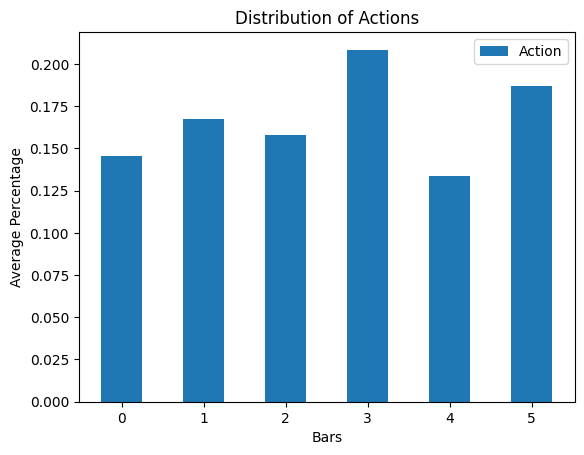

In [33]:


data = [
0.07951482479784366,
0.18912848158131176,
0.18778077268643306,
0.18014375561545373,
0.11904761904761904,
0.24438454627133874,
0.11956001912960305,
0.10377809660449545,
0.1951219512195122,
0.23290291726446677,
0.16307986609277858,
0.18555714968914394,
0.2251843448667045,
0.12422007941009643,
0.12081678956324447,
0.20079410096426545,
0.13783323879750425,
0.1911514463981849,
0.11116504854368932,
0.14029126213592233,
0.19805825242718447,
0.1650485436893204,
0.12184466019417475,
0.26359223300970874,
0.1875332978156633,
0.11134789557805008,
0.10495471497069792,
0.2956846030900373,
0.13052743740010656,
0.16995205114544487,
0.1415977961432507,
0.2716253443526171,
0.13829201101928373,
0.20606060606060606,
0.09807162534435261,
0.1443526170798898,
0.12937433722163308,
0.21580063626723223,
0.12142099681866383,
0.21314952279957583,
0.12725344644750794,
0.19300106044538706,
0.11672473867595819,
0.21312427409988385,
0.1957026713124274,
0.21022067363530778,
0.10104529616724739,
0.16318234610917537,
0.16978667827601218,
0.1632564214192425,
0.15150195907705702,
0.20330866347409665,
0.14453635176316934,
0.1676099259904223,
0.17512195121951218,
0.14390243902439023,
0.1648780487804878,
0.17658536585365853,
0.1902439024390244,
0.14926829268292682
]

print(len(data))

# Calculate the averages of every 6th value
averages = [np.mean(data[i:len(data):6]) for i in range(6)]

# Plotting
fig, ax = plt.subplots()
bar_width = 0.5
bar_positions = np.arange(len(averages))

ax.bar(bar_positions, averages, bar_width, label='Action')

# Add labels and title
ax.set_xlabel('Bars')
ax.set_ylabel('Average Percentage')
ax.set_title('Distribution of Actions')
ax.legend()

# Show the plot
plt.show()

In [34]:
fout = open('loss', 'wb')
# save losses
np.save(fout, np.array(losses))

fout2 = open('acc', 'wb')
np.save(fout2, np.array(accuracies))

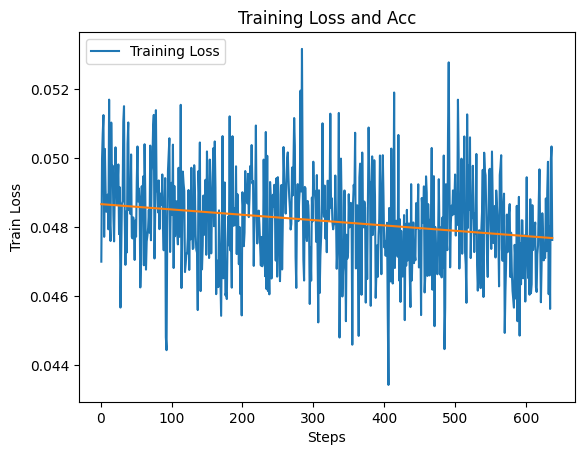

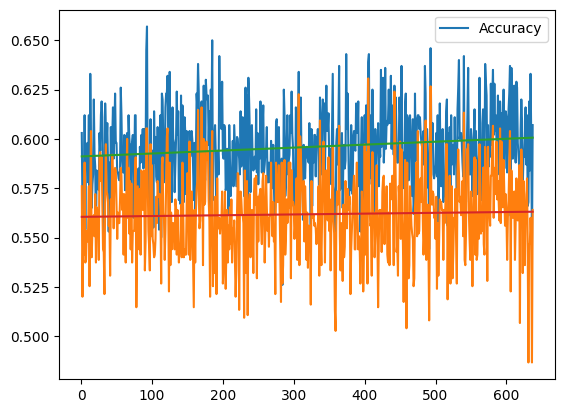

In [35]:
losses_ = losses[10:]
accuracies_ = accuracies[10:]
fake_accuracies_ = fake_accuracies[10:]

num_steps = len(losses_)

steps = range(1, num_steps+1)

plt.plot(steps, losses_, label='Training Loss')

plt.title('Training Loss and Acc')
plt.xlabel('Steps')
plt.ylabel('Train Loss')

# plt.xticks(np.arange(0, num_steps, 2))

#calculate equation for quadratic trendline
z = np.polyfit(steps, losses_, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(steps, p(steps))

plt.legend(loc='best')
plt.show()

plt.plot(steps, accuracies_, label='Accuracy')
plt.plot(steps, fake_accuracies_)

#calculate equation for quadratic trendline
z = np.polyfit(steps, accuracies_, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(steps, p(steps))

z = np.polyfit(steps, fake_accuracies_, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(steps, p(steps))

plt.legend(loc='best')
plt.show()


In [ ]:
# optimizer = None
# torch.cuda.empty_cache()
# evaluate()
# print(val_accuracies)

# save model

In [36]:
MODEL_TO_SAVE = "model_best.pt"  # careful!

# raise Exception("Don't Save When Running All")

storage_client = storage.Client("multi-dt-group8") # https://console.cloud.google.com/storage/browser/multi-dt-group8
bucket = storage_client.bucket("multi-dt-group8")
blob = bucket.blob("Pong/" + MODEL_TO_SAVE)

# state_dict is a reference
# best_model_state = deepcopy(model.state_dict())

with blob.open("wb", ignore_flush=True) as f:
   torch.save(model.state_dict(), f)

# with blob.open("rb") as f:
#     model.load_state_dict(torch.load("model.pt"))

# --- Save/Load model weights
# torch.save(model.state_dict(), "multi-dt-group8")
# model.load_state_dict(torch.load("model.pth"))


# create envs

In [ ]:


# --- Create environments
class SequenceEnvironmentWrapper(gym.Wrapper):
    def __init__(self, env, num_stack_frames: int = 1, jpeg_obs: bool = False):
        super().__init__(env)
        self.num_stack_frames = num_stack_frames
        self.jpeg_obs = jpeg_obs

        self.obs_stack = collections.deque([], maxlen=self.num_stack_frames)
        self.act_stack = collections.deque([], maxlen=self.num_stack_frames)
        self.rew_stack = collections.deque([], maxlen=self.num_stack_frames)
        self.done_stack = collections.deque([], maxlen=self.num_stack_frames)
        self.info_stack = collections.deque([], maxlen=self.num_stack_frames)

    @property
    def observation_space(self):
        parent_obs_space = self.env.observation_space
        act_space = self.env.action_space
        episode_history = {
            "observations": gym.spaces.Box(
                np.stack([parent_obs_space.low] * self.num_stack_frames, axis=0),
                np.stack([parent_obs_space.high] * self.num_stack_frames, axis=0),
                dtype=parent_obs_space.dtype,
            ),
            "actions": gym.spaces.Box(0, act_space.n, [self.num_stack_frames], dtype=act_space.dtype),
            "rewards": gym.spaces.Box(-np.inf, np.inf, [self.num_stack_frames]),
        }
        return gym.spaces.Dict(**episode_history)

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        if self.jpeg_obs:
            obs = self._process_jpeg(obs)

        # Create a N-1 "done" past frames.
        self.pad_current_episode(obs, self.num_stack_frames - 1)
        # Create current frame (but with placeholder actions and rewards).
        self.obs_stack.append(obs)
        self.act_stack.append(0)
        self.rew_stack.append(0)
        self.done_stack.append(0)
        self.info_stack.append(None)
        return self._get_obs()

    def step(self, action: np.ndarray):
        """Replaces env observation with fixed length observation history."""
        # Update applied action to the previous timestep.
        self.act_stack[-1] = action
        obs, rew, done, info = self.env.step(action)
        if self.jpeg_obs:
            obs = self._process_jpeg(obs)
        self.rew_stack[-1] = rew
        # Update frame stack.
        self.obs_stack.append(obs)
        self.act_stack.append(0)  # Append unknown action to current timestep.
        self.rew_stack.append(0)
        self.info_stack.append(info)
        return self._get_obs(), rew, done, info

    def pad_current_episode(self, obs, n):
        # Prepad current episode with n steps.
        for _ in range(n):
            self.obs_stack.append(np.zeros_like(obs))
            self.act_stack.append(0)
            self.rew_stack.append(0)
            self.done_stack.append(1)
            self.info_stack.append(None)

    def _process_jpeg(self, obs):
        obs = np.expand_dims(obs, axis=-1)  # tf expects channel-last
        obs = tf.io.decode_jpeg(tf.io.encode_jpeg(obs))
        obs = np.array(obs).transpose(2, 0, 1)  # to channel-first
        return obs

    def _get_obs(self):
        r"""Return current episode's N-stacked observation.

        For N=3, the first observation of the episode (reset) looks like:

        *= hasn't happened yet.

        GOAL  OBS  ACT  REW  DONE
        =========================
        g0    0    0.   0.   True
        g0    0    0.   0.   True
        g0    x0   0.   0.   False

        After the first step(a0) taken, yielding x1, r0, done0, info0, the next
        observation looks like:

        GOAL  OBS  ACT  REW  DONE
        =========================
        g0    0    0.   0.   True
        g0    x0   0.   0.   False
        g1    x1   a0   r0   d0

        A more chronologically intuitive way to re-order the column data would be:

        PREV_ACT  PREV_REW  PREV_DONE CURR_GOAL CURR_OBS
        ================================================
        0.        0.        True      g0        0
        0.        0.        False*    g0        x0
        a0        r0        info0     g1        x1

        Returns:
        episode_history: np.ndarray of observation.
        """
        episode_history = {
            "observations": np.stack(self.obs_stack, axis=0),
            "actions": np.stack(self.act_stack, axis=0),
            "rewards": np.stack(self.rew_stack, axis=0),
        }
        return episode_history


# from https://github.com/facebookresearch/moolib/blob/06e7a3e80c9f52729b4a6159f3fb4fc78986c98e/examples/atari/environment.py
def create_env(env_name, sticky_actions=False, noop_max=30, terminal_on_life_loss=False):
    env = gym.make(  # Cf. https://brosa.ca/blog/ale-release-v0.7
        f"ALE/{env_name}-v5",
        obs_type="grayscale",  # "ram", "rgb", or "grayscale".
        frameskip=1,  # Action repeats. Done in wrapper b/c of noops.
        repeat_action_probability=0.25 if sticky_actions else 0.0,  # Sticky actions.
        max_episode_steps=108000 // 4,
        full_action_space=True,  # Use all actions.
        render_mode=None,  # None, "human", or "rgb_array".
    )

    # Using wrapper from seed_rl in order to do random no-ops _before_ frameskipping.
    # gym.wrappers.AtariPreprocessing doesn't play well with the -v5 versions of the game.
    env = AtariPreprocessing(
        env,
        frame_skip=4,
        terminal_on_life_loss=terminal_on_life_loss,
        screen_size=84,
        max_random_noops=noop_max,  # Max no-ops to apply at the beginning.
    )
    # env = gym.wrappers.FrameStack(env, num_stack=4)  # frame stack done separately
    env = SequenceEnvironmentWrapper(env, num_stack_frames=4, jpeg_obs=True)
    return env




# evaluate

In [ ]:
from IPython.display import display, clear_output

actions_arr = []

# --- Evaluate model
def _batch_rollout(envs, policy_fn, num_episodes, log_interval=None, render=False, offline_obs=None, offline_actions=None, offline_RTG=None, save_images=False):
    r"""Roll out a batch of environments under a given policy function."""
    num_batch = len(envs)
    num_steps = envs[0].spec.max_episode_steps
    assert num_episodes % num_batch == 0

    rng = torch.Generator()
    seeds_list = [random.randint(0, 2**32 - 1) for _ in range(num_episodes)]
    print(f"seeds: {seeds_list}")

    rew_sum_list = []
    for c in range(num_episodes // num_batch):
        seeds = seeds_list[c * num_batch : (c + 1) * num_batch]
        rng.manual_seed(seeds[0])

        obs_list = [env.reset(seed=seeds[i]) for i, env in enumerate(envs)]
        obs = {k: np.stack([obs[k] for obs in obs_list], axis=0) for k in obs_list[0]}
        rew_sum = np.zeros(num_batch, dtype=np.float32)
        done = np.zeros(num_batch, dtype=np.int32)
        start = time.perf_counter()
        for t in range(num_steps):
            done_prev = done
            obs = {k: torch.tensor(v, device=device) for k, v in obs.items()}
            actions = policy_fn(obs, rng=rng, deterministic=False)

            # Collect step results and stack as a batch.
            step_results = [env.step(act) for env, act in zip(envs, actions.cpu().numpy())]
            obs_list = [result[0] for result in step_results]
            obs = {k: np.stack([obs[k] for obs in obs_list], axis=0) for k in obs_list[0]}
            rew = np.stack([result[1] for result in step_results])
            done = np.stack([result[2] for result in step_results])

            actions_arr.append(actions.cpu().numpy())

            if len(envs)==1:
                clear_output(wait=True)
                image_to_visualize = obs["observations"][0][0]
                #print(obs["observations"][0])
                f, axarr = plt.subplots(1,2)
                # print(np.mean(image_to_visualize))
                # print(np.mean(offline_obs[t]))
                axarr[0].imshow(image_to_visualize.squeeze()/255.0, cmap='gray')
                if save_images:
                    # Save the image
                    savedir = "/content/images"
                    save_path = os.path.join(savedir, f"image{t}.png")
                    plt.savefig(save_path)

                if offline_obs is not None:
                    print(offline_actions[t])
                    axarr[1].imshow(offline_obs[t].squeeze()/255.0, cmap='gray')
                # axarr[0].title("Gym Observation")
                # axarr[1].title("Offline Observation")
                # axarr[0].axis('off')  # To hide the axis labels and ticks
                # axarr[1].axis('off')  # To hide the axis labels and ticks
                #Show the image
                plt.show()

            done = np.logical_or(done, done_prev).astype(np.int32)
            rew = rew * (1 - done)
            rew_sum += rew

            if log_interval and t % log_interval == 0:
                elapsed = time.perf_counter() - start
                print(f"step: {t}, fps: {(num_batch * t / elapsed):.2f}, done: {done.astype(np.int32)}, rew_sum: {rew_sum}")

            # Don't continue if all environments are done.
            if np.all(done):
                break

        rew_sum_list.append(rew_sum)
    return np.concatenate(rew_sum_list)



# run inference

In [ ]:
def map_actions_targets(actions):
    # Create a new tensor for modified actions
    replace = {1: 0, 2: 3, 3: 4, 4: 3, 5: 4} # map to full action set (16)

    for old_value, new_value in replace.items():
        actions[actions == old_value] = new_value
    return actions

obs, RTG, actions, rewards, decoded_obs = None, None, None, None, None

display_ds = load_shard(47)

for it, episode in enumerate(display_ds):
    obs, RTG, actions, rewards = get_episode(episode)
    actions = map_actions_targets(actions)
    decoded_obs = _decode_images(obs).numpy().transpose(0,3,1,2) # T, C, H, W
    break


In [ ]:
import copy

env_name = "Breakout"
num_envs = 1
env_fn = lambda: create_env(env_name)
envs = [env_fn() for _ in range(num_envs)]
print(f"num_envs: {num_envs}", envs[0])

mean= 100
std= 10

print(envs[0].unwrapped.get_action_meanings())

model.eval()
optimal_action_fn = functools.partial(
    model.optimal_action,
    return_range=RETURN_RANGE,
    single_return_token=True,
    opt_weight=0,
    num_samples=128,
    action_temperature=0.5,
    return_temperature=0.75,
    action_top_percentile=50,
    return_top_percentile=10,
)

def max_action(inputs, rng, deterministic):
    temp = 0.01
    logits_fn = model.forward
    obs, act, rew = inputs["observations"], inputs["actions"], inputs["rewards"]
    inputs_with_rtg = copy.deepcopy(inputs)
    # print(inputs["rewards"].cpu().numpy())
    inputs_with_rtg["returns-to-go"] = 21 - torch.cumsum(inputs["rewards"]==-1, dim=-1)
    # inputs_with_rtg["returns-to-go"] = 21 - torch.cumsum(inputs["rewards"], dim=-1)
    # print(inputs_with_rtg["returns-to-go"].cpu().numpy())
    # print(inputs_with_rtg["returns-to-go"].cpu().numpy())
    # print(inputs["rewards"].cpu().numpy())
    action = sample_from_logits(logits_fn(inputs_with_rtg)["action_logits"][:, -1, :], temperature=temp)
    # print(action.detach().cpu().numpy())
    return action


def sample_from_logits_(
    logits: Tensor,
    mean=mean,
    std=std,
    generator: Optional[torch.Generator] = None,
    # deterministic: Optional[bool] = False,
    temperature: Optional[float] = 1e0,
    top_k: Optional[int] = None,
    top_percentile: Optional[float] = None,
) -> Tuple[Tensor, Tensor]:
    normal = D.Normal(loc=mean, scale=std)
    input = torch.Tensor(np.arange(-20,100)).to(device)
    likelihood = torch.exp(normal.log_prob(input))
    sample = D.Categorical(logits= likelihood * temperature * logits).sample()
    # probs = F.softmax(temperature * logits, dim=-1)
    # sample = torch.multinomial(probs, num_samples=1, generator=generator)
    return sample


def optimal_action(
        inputs: Mapping[str, Tensor],
        return_range: Tuple[int] = (-100, 100),
        single_return_token: bool = False,
        opt_weight: Optional[float] = 0.0,
        num_samples: Optional[int] = 128,
        action_temperature: Optional[float] = 1.0,
        return_temperature: Optional[float] = 1.0,
        action_top_percentile: Optional[float] = None,
        return_top_percentile: Optional[float] = None,
        rng: Optional[torch.Generator] = None,
        deterministic: bool = False,
    ):
        r"""Calculate optimal action for the given sequence model."""
        logits_fn = model.forward
        obs, act, rew = inputs["observations"], inputs["actions"], inputs["rewards"]
        assert len(obs.shape) == 5
        assert len(act.shape) == 2
        inputs = {
            "observations": obs,
            "actions": act,
            "rewards": rew,
            "returns-to-go": torch.zeros_like(act),
        }
        sequence_length = obs.shape[1]
        # Use samples from the last timestep.
        timestep = -1
        # A biased sampling function that prefers sampling larger returns.
        def ret_sample_fn(rng, logits):
            assert len(logits.shape) == 2
            # Add optimality bias.
            if opt_weight > 0.0:
                # Calculate log of P(optimality=1|return) := exp(return) / Z.
                logits_opt = torch.linspace(0.0, 1.0, logits.shape[1])
                logits_opt = torch.repeat_interleave(logits_opt[None, :], logits.shape[0], dim=0)
                # Sample from log[P(optimality=1|return)*P(return)].
                logits = logits + opt_weight * logits_opt
            logits = torch.repeat_interleave(logits[None, ...], num_samples, dim=0)
            ret_sample = sample_from_logits_(
                logits,
                generator=rng,
                temperature=return_temperature,
                top_percentile=return_top_percentile,
            )
            # Pick the highest return sample.
            ret_sample, _ = torch.max(ret_sample, dim=0)
            # Convert return tokens into return values.
            ret_sample = decode_return(ret_sample, return_range)
            return ret_sample

        # Set returns-to-go with an (optimistic) autoregressive sample.
        if single_return_token:
            # Since only first return is used by the model, only sample that (faster).
            ret_logits = logits_fn(inputs)["return_logits"][:, 0, :]
            ret_sample = ret_sample_fn(rng, ret_logits)
            inputs["returns-to-go"][:, 0] = ret_sample

        # Generate a sample from action logits.
        act_logits = logits_fn(inputs)["action_logits"][:, timestep, :]
        act_sample = sample_from_logits(
            act_logits,
            generator=rng,
            deterministic=deterministic,
            temperature=action_temperature,
            top_percentile=action_top_percentile,
        )
        return act_sample

def test_action(inputs, rng, deterministic):
    return torch.tensor([5])

max_action_fn = functools.partial(max_action)
test_action_fn = functools.partial(test_action)
target_distribution = functools.partial(
    optimal_action,
    return_range=RETURN_RANGE,
    single_return_token=True,
    opt_weight=0,
    num_samples=128,
    action_temperature=0.5,
    return_temperature=0.75,
    action_top_percentile=None,
    return_top_percentile=None,
)

task_results = {}
task_results["rew_sum"] = _batch_rollout(envs, max_action_fn, num_episodes=64, log_interval=50, offline_obs=None, offline_actions=actions, offline_RTG= RTG)
[env.close() for env in envs]

# --- Log metrics
def print_metrics(metric):
    print(f"mean: {np.mean(metric):.2f}")
    print(f"std: {np.std(metric):.2f}")
    print(f"median: {np.median(metric):.2f}")
    print(f"iqm: {scipy.stats.trim_mean(metric, proportiontocut=0.25):.2f}")


print("rew_sum")
print_metrics(task_results["rew_sum"])

print("-" * 10)

task_results["human_normalized_score"] = [
    get_human_normalized_score(env_name.lower(), score) for score in task_results["rew_sum"]
]
print("human_normalized_score")
print_metrics(task_results["human_normalized_score"])

# New Section

In [ ]:
# task_results["mean_rew_sum"] = np.mean(task_results["rew_sum"])
# task_results["std_rew_sum"] = np.std(task_results["rew_sum"])
# task_results["median_rew_sum"] = np.median(task_results["rew_sum"])
# task_results["iqm_rew_sum"] = scipy.stats.trim_mean(task_results["rew_sum"], proportiontocut=0.25)

# task_results["mean_human_normalized_score"] = np.mean(task_results["human_normalized_score"])
# task_results["std_human_normalized_score"] = np.std(task_results["human_normalized_score"])
# task_results["median_human_normalized_score"] = np.median(task_results["human_normalized_score"])
# task_results["iqm_human_normalized_score"] = scipy.stats.trim_mean(task_results["human_normalized_score"], proportiontocut=0.25)


# # --- Save results
# np.savez("results.npz", **task_results)

In [ ]:
print(actions_arr)

In [ ]:
# Plotting
actions_dist = np.zeros((5,))
total_count = 0

for actions in actions_arr:
    values, counts = np.unique(actions, return_counts=True)
    for value, count in zip(values, counts):
        if value <= 4:
            actions_dist[value] += count
            total_count += count

fig, ax = plt.subplots()
bar_width = 0.5
bar_positions = np.arange(len(actions_dist))

ax.bar(bar_positions, actions_dist/total_count, bar_width, label='Action')

# Add labels and title
ax.set_xlabel('Action')
ax.set_ylabel('Average Percentage')
ax.set_title('Distribution of Actions')
ax.legend()

# Show the plot
plt.show()